In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

# Data Preprocessing

In [128]:
data = pd.read_csv('./Traffic_accidents.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4265 entries, 0 to 4264
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   OBJECTID              4265 non-null   int64 
 1   DATE_                 4265 non-null   object
 2   TIME                  4265 non-null   int64 
 3   SEVERITY              4265 non-null   int64 
 4   SEVERITY_DESCRIPTION  4265 non-null   object
 5   ACCIDENT_TYPE         4265 non-null   object
 6   ACCIDENT_DESCRIPTION  4265 non-null   object
 7   VEHICLES              4265 non-null   int64 
 8   CASUALTIES            4265 non-null   int64 
 9   PEDESTRIAN            4265 non-null   int64 
 10  CYCLES                4265 non-null   int64 
 11  MCYCLES               4265 non-null   int64 
 12  CHILDREN              4265 non-null   int64 
 13  OAPS                  4265 non-null   int64 
 14  X                     4265 non-null   int64 
 15  Y                     4265 non-null   

In [129]:
data.head(3)

,OBJECTID,DATE_,TIME,SEVERITY,SEVERITY_DESCRIPTION,ACCIDENT_TYPE,ACCIDENT_DESCRIPTION,VEHICLES,CASUALTIES,PEDESTRIAN,CYCLES,MCYCLES,CHILDREN,OAPS,X,Y,RENDER
0,1,2017/02/02 00:00:00+00,720,3,Slight,LC,Loss of Control,2,2,0,1,1,0,0,360035,175918,CYC
1,2,2017/02/02 00:00:00+00,1803,3,Slight,J,Turning movement ¿ unidentified priority,2,1,0,1,0,0,0,359039,172053,CYC
2,3,2017/02/03 00:00:00+00,2021,3,Slight,J2,Turning Movement from minor road,2,1,0,1,0,0,0,362596,175377,CYC


In [130]:
data.isnull().sum()

OBJECTID                0
DATE_                   0
TIME                    0
SEVERITY                0
SEVERITY_DESCRIPTION    0
ACCIDENT_TYPE           0
ACCIDENT_DESCRIPTION    0
VEHICLES                0
CASUALTIES              0
PEDESTRIAN              0
CYCLES                  0
MCYCLES                 0
CHILDREN                0
OAPS                    0
X                       0
Y                       0
RENDER                  0
dtype: int64

<Axes: >

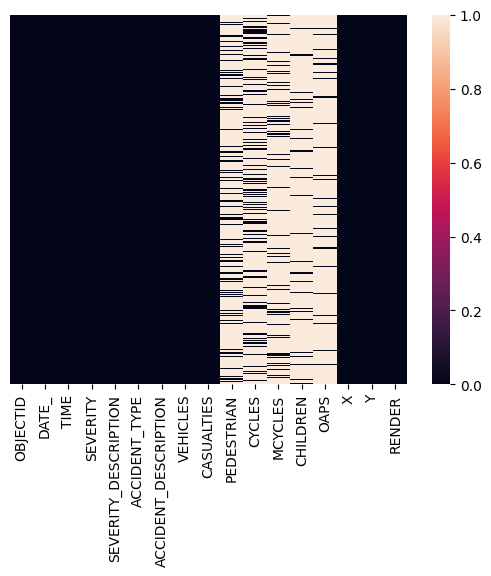

In [131]:
sns.heatmap(data == 0, yticklabels=False)

In [132]:
data.drop(['OBJECTID', 'DATE_', 'TIME', 'SEVERITY_DESCRIPTION', 'CASUALTIES', 'ACCIDENT_TYPE',
           'ACCIDENT_DESCRIPTION', 'X', 'Y', 'RENDER'], axis=1, inplace=True)
# converting fatal collisions to serious
data['SEVERITY'] = data['SEVERITY'].replace(1, 2)
data.head(3)

,SEVERITY,VEHICLES,PEDESTRIAN,CYCLES,MCYCLES,CHILDREN,OAPS
0,3,2,0,1,1,0,0
1,3,2,0,1,0,0,0
2,3,2,0,1,0,0,0


In [133]:
slight = pd.get_dummies(data["SEVERITY"], dtype=int, drop_first=True)
data = pd.concat([data, slight], axis=1)
data.drop(['SEVERITY'], axis=1, inplace=True)
data.rename(columns={3: 'Severe'}, inplace=True)
# inverting the severe column
data['Severe'] = data['Severe'] ^ 1
data.head(30)


,VEHICLES,PEDESTRIAN,CYCLES,MCYCLES,CHILDREN,OAPS,Severe
0,2,0,1,1,0,0,0
1,2,0,1,0,0,0,0
2,2,0,1,0,0,0,0
3,2,0,0,0,0,0,0
4,1,1,0,0,0,0,0
5,1,1,0,1,0,0,0
6,2,0,1,0,0,0,0
7,2,0,1,0,0,0,0
8,2,0,0,1,0,0,0
9,2,0,0,0,0,1,0


<h1> Balancing the dataset </h1>

In [134]:
# Counting the occurrences of each class
class_counts = data['Severe'].value_counts()

minority_class_label = class_counts.idxmin()
majority_class_label = class_counts.idxmax()

majority_class_indices = data[data['Severe'] == majority_class_label].index

num_samples_minority_class = class_counts[minority_class_label]

undersampled_majority_indices = data[data['Severe'] == majority_class_label].sample(n=num_samples_minority_class,
                                                                                    random_state=42).index

undersampled_indices = data[data['Severe'] == minority_class_label].index.union(undersampled_majority_indices)

undersampled_data = data.loc[undersampled_indices]

undersampled_data.head(145)

data = undersampled_data
data.head(10)

,VEHICLES,PEDESTRIAN,CYCLES,MCYCLES,CHILDREN,OAPS,Severe
12,1,1,0,0,0,0,0
14,1,1,0,0,0,0,0
17,1,0,0,1,0,0,0
26,2,0,0,0,1,0,0
27,2,0,0,0,0,1,1
28,2,0,0,1,0,0,1
34,2,0,0,0,0,0,0
35,2,0,1,0,0,0,0
36,2,1,0,0,0,0,1
41,1,1,0,0,0,0,1


# Performance Evaluation Functions

In [135]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$Age$", fontsize=15)
    plt.ylabel(r"$Glucose$", fontsize=15, rotation=90)

In [136]:
results = []


def add_results(result):
    results.append(result)


def get_results():
    print("Model, Test Avg. Accuracy, Test Avg. Precision")
    return results

In [137]:
def evaluate_model(model):
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    accu_score = accuracy_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)
    print("\nConfusion Matrix:")
    print(matrix)
    print("\nClassification Report:")
    print(class_report)
    print("\nAccuracy Score")
    print(accu_score)
    print("\n")
    print('\nAverage accuracy: ', np.mean(scores))

    # doing k fold cross validation for precision
    scores_test = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=10, n_jobs=-1)

    print('\nTest average accuracy: ', np.mean(scores_test))

    scores = cross_val_score(model, X_train, y_train, scoring='precision_macro', cv=10, n_jobs=-1)
    # print the average score
    print('\nAverage precision: ', scores.mean())

    # doing k fold cross validation for accuracy
    scores_test = cross_val_score(model, X_test, y_test, scoring='precision_macro', cv=10, n_jobs=-1)

    print('\nTest average precision: ', scores_test.mean())

<h1> Splitting dataset </h1>

In [138]:
X = data.drop(['Severe'], axis=1)
y = data['Severe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<h1> Support Vector Machine </h1>

In [139]:
linear_svm_model = SVC(kernel='linear', random_state=0)
linear_svm_pipeline = make_pipeline(StandardScaler(), linear_svm_model)

poly_svm_model = SVC(kernel='poly', random_state=0)
poly_svm_pipeline = make_pipeline(StandardScaler(), poly_svm_model)

rbf_svm_model = SVC(kernel='rbf', random_state=0)
rbf_svm_pipeline = make_pipeline(StandardScaler(), rbf_svm_model)


In [140]:
linear_svm_pipeline.fit(X_train, y_train)
poly_svm_pipeline.fit(X_train, y_train)
rbf_svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [141]:
print("Linear Support Vector Machine:")
evaluate_model(model=linear_svm_pipeline)

Linear Support Vector Machine:

Confusion Matrix:
[[78 38]
 [54 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       116
           1       0.66      0.57      0.61       127

    accuracy                           0.62       243
   macro avg       0.62      0.62      0.62       243
weighted avg       0.63      0.62      0.62       243


Accuracy Score
0.6213991769547325



Average accuracy:  0.6173558897243108

Test average accuracy:  0.5838333333333334

Average precision:  0.6231066252225561

Test average precision:  0.589187364922659


In [142]:
print("Polynomial Support Vector Machine:")
evaluate_model(model=poly_svm_pipeline)

Polynomial Support Vector Machine:

Confusion Matrix:
[[75 41]
 [60 67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.65      0.60       116
           1       0.62      0.53      0.57       127

    accuracy                           0.58       243
   macro avg       0.59      0.59      0.58       243
weighted avg       0.59      0.58      0.58       243


Accuracy Score
0.5843621399176955



Average accuracy:  0.5943922305764412

Test average accuracy:  0.5594999999999999

Average precision:  0.6027641565770435

Test average precision:  0.5709107799665076


In [143]:
print("Radial Basis Function Support Vector Machine:")
evaluate_model(model=rbf_svm_pipeline)

Radial Basis Function Support Vector Machine:

Confusion Matrix:
[[73 43]
 [47 80]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       116
           1       0.65      0.63      0.64       127

    accuracy                           0.63       243
   macro avg       0.63      0.63      0.63       243
weighted avg       0.63      0.63      0.63       243


Accuracy Score
0.6296296296296297



Average accuracy:  0.6264097744360904

Test average accuracy:  0.5965

Average precision:  0.6325745644407313

Test average precision:  0.6036849480928429


<h1> Hyperparameter Tuning: </h1>

<h2> Linear Kernel Tuning: </h2>

<p> Narrowing Down on best C hyper parameter </p>

In [144]:
parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=linear_svm_model, param_grid=parameter_grid, scoring='accuracy', n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 1}


In [145]:
parameter_grid = {'C': np.linspace(0.1, 10, num=100, dtype=float)}

grid_search = GridSearchCV(estimator=linear_svm_model, param_grid=parameter_grid, scoring='accuracy', n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 3.0000000000000004}


Best hyper parameters for linear kernel is 3 for the C hyper parameter.

<h2> Polynomial kernel tuning: </h2>

In [146]:
parameter_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                  'degree': [1, 2, 3, 4],
                  'gamma': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(estimator=poly_svm_model, param_grid=parameter_grid, scoring='accuracy', cv=3, n_jobs=- 1,
                           verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters {'C': 0.01, 'degree': 2, 'gamma': 1}


The best hyperparameters found for the polynomial kernel are: 
C = 0.01
degree = 2
gamma = 1


<h2> Radial Basis Function kernel tuning: </h2>

In [147]:
parameter_grid = {'C': [0.01, 0.1, 1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=rbf_svm_model, param_grid=parameter_grid, scoring='accuracy', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 10, 'gamma': 0.1}


In [148]:
parameter_grid = {'C': np.linspace(1, 100, num=100, dtype=float), 'gamma': np.linspace(0.01, 1, num=100, dtype=float)}
grid_search = GridSearchCV(estimator=rbf_svm_model, param_grid=parameter_grid, scoring='accuracy', cv=3, n_jobs=- 1)
grid_search.fit(X_train, y_train)
print("Best Parameters", grid_search.best_params_)

Best Parameters {'C': 18.0, 'gamma': 0.09}


The best hyperparameters found for the Radial Basis Function Kernel are: C = 18.0, gamma = 0.09

<p>Linear Kernel: C = 3</p>
<p>Poly Kernel: C = 0.01, gamma = 1, degree = 2</p>
<p>RBF Kernel:  C = 18.0, gamma = 0.09</p>

<h1> Tuned Support Vector Machine Model Evaluation: </h1>

In [149]:
linear_svm_model = SVC(kernel='linear', C=3, random_state=0)
linear_svm_pipeline = make_pipeline(StandardScaler(), linear_svm_model)

poly_svm_model = SVC(kernel='poly', C=0.01, gamma=1, degree=2, random_state=0)
poly_svm_pipeline = make_pipeline(StandardScaler(), poly_svm_model)

rbf_svm_model = SVC(kernel='rbf', C=18.0, gamma=0.09, random_state=0)
rbf_svm_pipeline = make_pipeline(StandardScaler(), rbf_svm_model)

In [150]:
linear_svm_pipeline.fit(X_train, y_train)
poly_svm_pipeline.fit(X_train, y_train)
rbf_svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=18.0, gamma=0.09, random_state=0))])

In [151]:
print("Tuned Linear Support Vector Machine:")
evaluate_model(model=linear_svm_pipeline)

Tuned Linear Support Vector Machine:

Confusion Matrix:
[[82 34]
 [59 68]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       116
           1       0.67      0.54      0.59       127

    accuracy                           0.62       243
   macro avg       0.62      0.62      0.62       243
weighted avg       0.63      0.62      0.62       243


Accuracy Score
0.6172839506172839



Average accuracy:  0.6174185463659148

Test average accuracy:  0.5838333333333333

Average precision:  0.6227470999357052

Test average precision:  0.588618766854061


In [152]:
print("Tuned Polynomial Support Vector Machine:")
evaluate_model(model=poly_svm_pipeline)

Tuned Polynomial Support Vector Machine:

Confusion Matrix:
[[78 38]
 [58 69]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       116
           1       0.64      0.54      0.59       127

    accuracy                           0.60       243
   macro avg       0.61      0.61      0.60       243
weighted avg       0.61      0.60      0.60       243


Accuracy Score
0.6049382716049383



Average accuracy:  0.6104010025062657

Test average accuracy:  0.5843333333333335

Average precision:  0.6172682823173326

Test average precision:  0.5910721957780782


In [153]:
print("Tuned Radial Basis Function Support Vector Machine:")
evaluate_model(model=rbf_svm_pipeline)

Tuned Radial Basis Function Support Vector Machine:

Confusion Matrix:
[[73 43]
 [46 81]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       116
           1       0.65      0.64      0.65       127

    accuracy                           0.63       243
   macro avg       0.63      0.63      0.63       243
weighted avg       0.63      0.63      0.63       243


Accuracy Score
0.6337448559670782



Average accuracy:  0.6175125313283207

Test average accuracy:  0.5965

Average precision:  0.6235605061159479

Test average precision:  0.6020136807636808


Overall the support vector machine with the radial basis function kernel performed the best once tuned over all the other kernels.
With the average accuracy and test average accuracy greater than any other kernel. The radial basis function kernel also had the highest f1-score of all of the other kernels.

<h1> Ensemble model testing: </h1>

In [154]:
ensemble_model = RandomForestClassifier(random_state=0, n_jobs=-1)
ensemble_pipe_line = make_pipeline(StandardScaler(), ensemble_model)
ensemble_pipe_line.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=0))])

In [155]:
evaluate_model(ensemble_pipe_line)


Confusion Matrix:
[[74 42]
 [48 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       116
           1       0.65      0.62      0.64       127

    accuracy                           0.63       243
   macro avg       0.63      0.63      0.63       243
weighted avg       0.63      0.63      0.63       243


Accuracy Score
0.6296296296296297



Average accuracy:  0.6139724310776943

Test average accuracy:  0.5998333333333334

Average precision:  0.6203029434579196

Test average precision:  0.6030389708330884


<h2> Tuning ensemble hyperparameters: </h2> 

In [156]:
parameter_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

random_search = GridSearchCV(estimator=ensemble_model, param_grid=parameter_grid,
                             cv=3, scoring='accuracy', n_jobs=- 1)
random_search.fit(X_train, y_train)
print("Best Parameters", random_search.best_params_)

Best Parameters {'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25}


In [157]:
ensemble_model = RandomForestClassifier(max_depth=3, max_features='sqrt', max_leaf_nodes=9, n_estimators=25,
                                        random_state=0, n_jobs=-1)
ensemble_pipe_line = make_pipeline(StandardScaler(), ensemble_model)
ensemble_pipe_line.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3, max_leaf_nodes=9,
                                        n_estimators=25, n_jobs=-1,
                                        random_state=0))])

In [158]:
evaluate_model(ensemble_pipe_line)


Confusion Matrix:
[[79 37]
 [49 78]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       116
           1       0.68      0.61      0.64       127

    accuracy                           0.65       243
   macro avg       0.65      0.65      0.65       243
weighted avg       0.65      0.65      0.65       243


Accuracy Score
0.6460905349794238



Average accuracy:  0.6192042606516291

Test average accuracy:  0.6091666666666666

Average precision:  0.6240834177090739

Test average precision:  0.6159677781368958


<h1> Final Results: </h1>

<p> The best model was the ensemble model, giving a higher average and test average accuracy / precision than the runner up model being the radial basis function support vector machine </p>
<p> Ensemble model: average accuracy = 0.619, test average accuracy = 0.609, average precision = 0.624, test average precision = 0.616</p>
<p> Radial Basis Function SVM: average accuracy = 0.618, test average accuracy = 0.597, average precision = 0.624, test average precision = 0. 602</p>
<p> The f1-score for the ensemble model was higher overall with class 0 being 0.65 and class 1 being 0.64, compared to the svm which got an f1 score for class 0 of 0.62 and an f1 score for class 1 of 0.65 </p>
<p> Overall the accuracies are relativley low, probabbly due to the lack of serious and fatal collisions in the dataset forcing undersampling of slight collisions </p>